# Transforming Series

In [8]:
import numpy as np
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
import random
from scipy.stats import gumbel_r, lognorm, cauchy
from dotenv import load_dotenv
import os


In [9]:
# Max Loss Function

def l_infinity_loss(y_true, y_pred):
    return tf.reduce_max(tf.abs(y_true - y_pred), axis=-1)

### Gumbel

Expected Value: $E(X)=\mu+\beta\gamma$ where $\gamma$ is Euler-Mascheroni constant

Median Value: $q^{0.5}_X = \mu - \beta \ln(\ln(2))$

Difference: $E(X)-q^{0.5}_X = \beta (\gamma+\ln(\ln(2))) \approx \beta \times 0.210703$

In [10]:
# Seed
seed = 3254
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

# Loss functions dictionary
loss_functions = {
    "L1": "mae",
    "L2": "mse",
    "L_inf": l_infinity_loss,
}

# NN and series specifications
seq_length = 500   # number of time steps (moments)
num_examples = 100  # number of examples (noise realizations)
batch_size = 16
epochs = 250
learning_rate = 0.01
x = np.linspace(0, 1, seq_length)

# Different sine wave variations
y_clean_dict = {
    "U-shape": np.sin(x + 3*np.pi),  # Original
    "Inverted U": np.sin(2 * np.pi * x),  # One full oscillation
    "Half U": np.sin(np.pi * x)  # Half oscillation
}

# Noise parameters
loc = 0
scale = 1  # Controlling noise level
theory_mean = scale * np.euler_gamma
theory_median = scale * np.log(np.log(2))

mean_array = np.array([theory_mean] * (num_examples * seq_length)).reshape(num_examples, seq_length)
median_array = np.array([theory_median] * (num_examples * seq_length)).reshape(num_examples, seq_length)

# PDF

x_pdf = np.linspace(-5, 10, 1000)
pdf = gumbel_r.pdf(x_pdf, loc=-theory_mean, scale=scale)

for shape, y_clean in y_clean_dict.items():
    print(f"Training model for: {shape}")
    
    # Create arrays
    x_repeated = np.tile(x, (num_examples, 1))
    np.random.seed(32)
    noise = np.random.gumbel(loc=loc, scale=scale, size=num_examples * seq_length).reshape(num_examples, seq_length)
    data = np.tile(y_clean, (num_examples, 1)) + noise - mean_array
    target = np.tile(y_clean, (num_examples, 1))

    # Create and estimate models
    model = keras.models.Sequential([
        keras.layers.Input(shape=(seq_length,)),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(seq_length, activation='linear')
    ])

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    predict = {}
    errors = {}

    for title, selected_loss in loss_functions.items():
        model.compile(optimizer=optimizer, loss=selected_loss)
        model.fit(x=x_repeated, y=data, batch_size=batch_size, epochs=epochs, verbose=0)
        predictions = model.predict(x_repeated)
        predict[title] = predictions[0]
        errors[title] = data - np.array(predictions[0])

Training model for: U-shape
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000021CC680E160> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
Training model for: Inverted U


KeyboardInterrupt: 

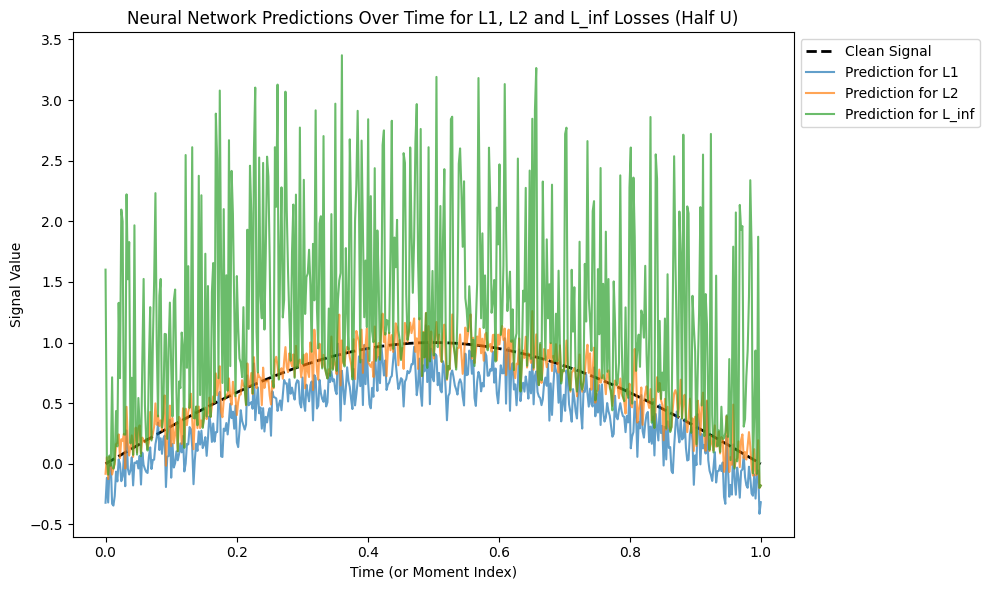

1.6517595102018552
1.6424629336527956
2.1282566776167444


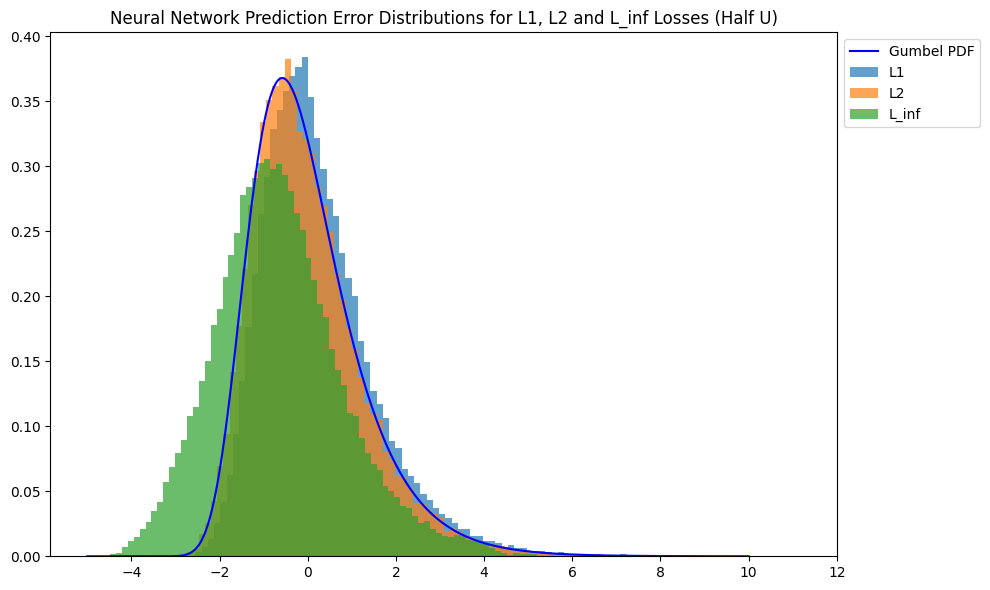

Observed Mean Difference:  0.2321
Theoretical Difference:  0.21070274431986852


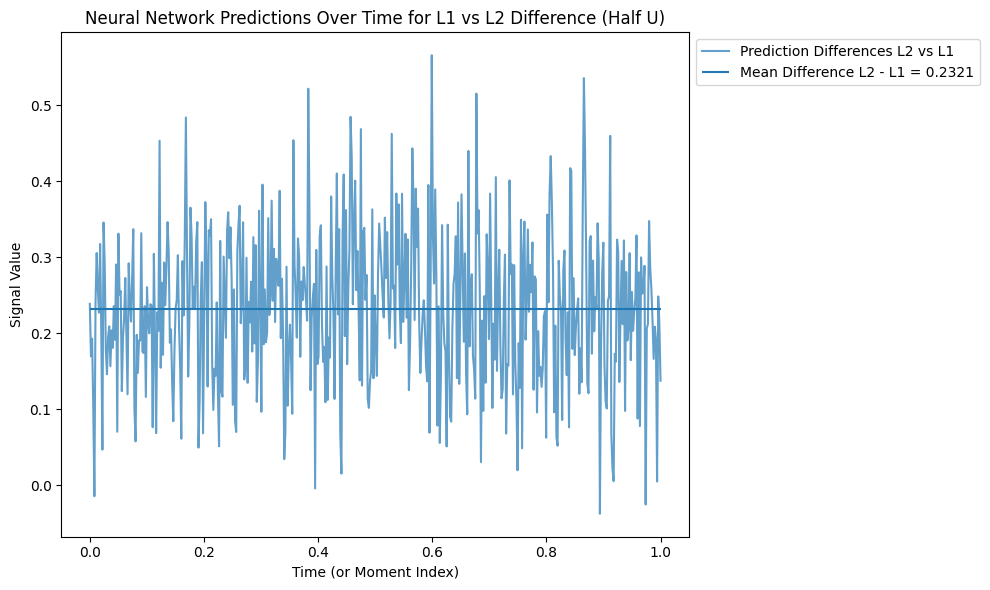

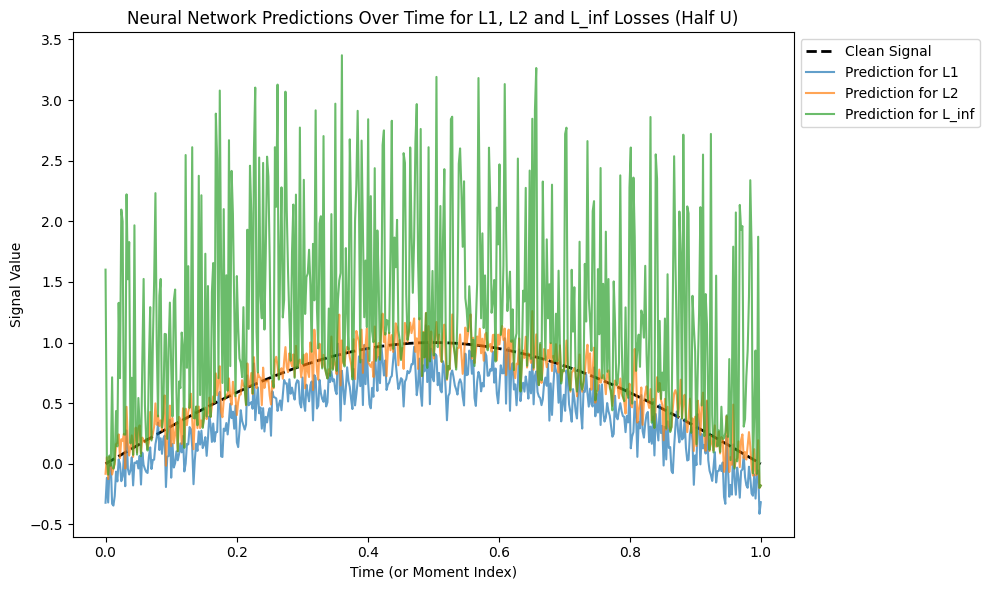

1.6517595102018552
1.6424629336527956
2.1282566776167444


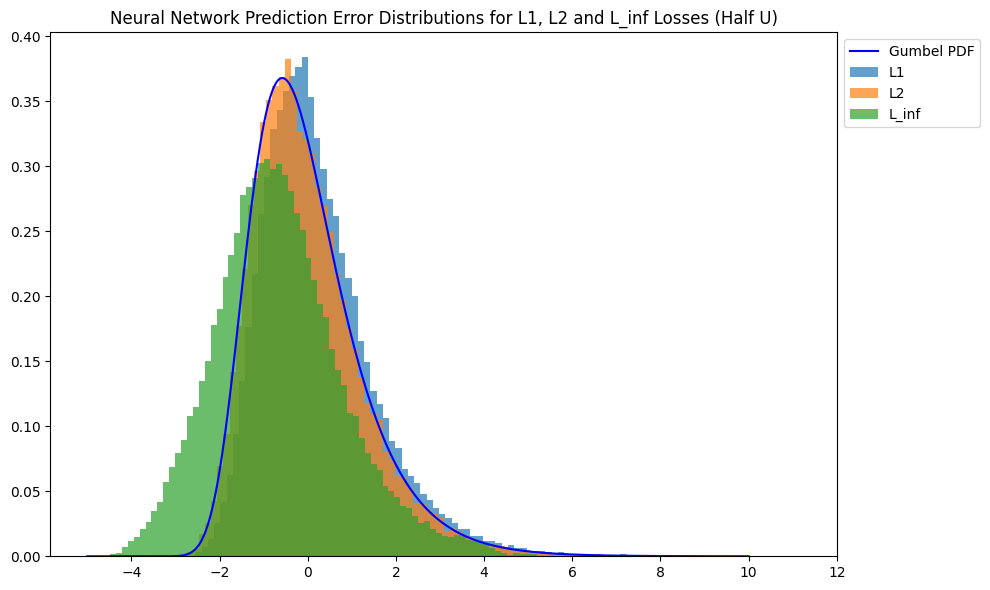

Observed Mean Difference:  0.2321
Theoretical Difference:  0.21070274431986852


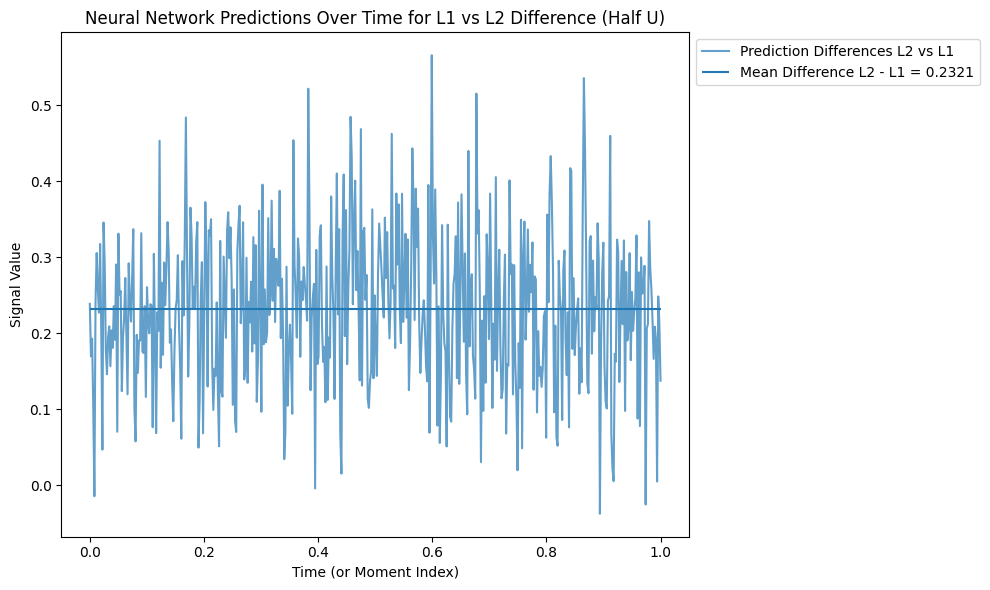

In [ ]:

# Plot results for L1, L2 and L_inf losses
plt.figure(figsize=(10, 6))
plt.plot(x, y_clean, 'k--', linewidth=2, label='Clean Signal')
plt.plot(x, predict["L1"], label=f'Prediction for L1', alpha=0.7)
plt.plot(x, predict["L2"], label=f'Prediction for L2', alpha=0.7)
plt.plot(x, predict["L_inf"], label=f'Prediction for L_inf', alpha=0.7)
plt.xlabel("Time (or Moment Index)")
plt.ylabel("Signal Value")
plt.title(f"Neural Network Predictions Over Time for L1, L2 and L_inf Losses ({shape})")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

print(np.var(errors["L1"]))
print(np.var(errors["L2"]))
print(np.var(errors["L_inf"]))

# Plot results for L1, L2 and L_inf losses
plt.figure(figsize=(10, 6))
plt.plot(x_pdf, pdf, label='Gumbel PDF', color='blue')
plt.hist(errors["L1"].flatten(), bins=100, alpha=0.7, label='L1', density=True)
plt.hist(errors["L2"].flatten(), bins=100, alpha=0.7, label='L2', density=True)
plt.hist(errors["L_inf"].flatten(), bins=100, alpha=0.7, label='L_inf', density=True)
plt.title(f"Neural Network Prediction Error Distributions for L1, L2 and L_inf Losses ({shape})")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

# Compute and plot difference between L2 and L1 predictions
diff_series = np.array(predict["L2"] - predict["L1"])
diff_mean = np.mean(predict["L2"] - predict["L1"])
mean_rounded = str(round(diff_mean, 4))
theoretical_diff = scale * (np.euler_gamma + np.log(np.log(2)))

print("Observed Mean Difference: ", mean_rounded)
print("Theoretical Difference: ", theoretical_diff)

plt.figure(figsize=(10, 6))
plt.plot(x, diff_series, label=f'Prediction Differences L2 vs L1', alpha=0.7)
plt.hlines(y=diff_mean, label=f'Mean Difference L2 - L1 = {mean_rounded}', xmin=0, xmax=1)
plt.xlabel("Time (or Moment Index)")
plt.ylabel("Signal Value")
plt.title(f"Neural Network Predictions Over Time for L1 vs L2 Difference ({shape})")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()
# Plot results for L1, L2 and L_inf losses
plt.figure(figsize=(10, 6))
plt.plot(x, y_clean, 'k--', linewidth=2, label='Clean Signal')
plt.plot(x, predict["L1"], label=f'Prediction for L1', alpha=0.7)
plt.plot(x, predict["L2"], label=f'Prediction for L2', alpha=0.7)
plt.plot(x, predict["L_inf"], label=f'Prediction for L_inf', alpha=0.7)
plt.xlabel("Time (or Moment Index)")
plt.ylabel("Signal Value")
plt.title(f"Neural Network Predictions Over Time for L1, L2 and L_inf Losses ({shape})")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

print(np.var(errors["L1"]))
print(np.var(errors["L2"]))
print(np.var(errors["L_inf"]))

# Plot results for L1, L2 and L_inf losses
plt.figure(figsize=(10, 6))
plt.plot(x_pdf, pdf, label='Gumbel PDF', color='blue')
plt.hist(errors["L1"].flatten(), bins=100, alpha=0.7, label='L1', density=True)
plt.hist(errors["L2"].flatten(), bins=100, alpha=0.7, label='L2', density=True)
plt.hist(errors["L_inf"].flatten(), bins=100, alpha=0.7, label='L_inf', density=True)
plt.title(f"Neural Network Prediction Error Distributions for L1, L2 and L_inf Losses ({shape})")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

# Compute and plot difference between L2 and L1 predictions
diff_series = np.array(predict["L2"] - predict["L1"])
diff_mean = np.mean(predict["L2"] - predict["L1"])
mean_rounded = str(round(diff_mean, 4))
theoretical_diff = scale * (np.euler_gamma + np.log(np.log(2)))

print("Observed Mean Difference: ", mean_rounded)
print("Theoretical Difference: ", theoretical_diff)

plt.figure(figsize=(10, 6))
plt.plot(x, diff_series, label=f'Prediction Differences L2 vs L1', alpha=0.7)
plt.hlines(y=diff_mean, label=f'Mean Difference L2 - L1 = {mean_rounded}', xmin=0, xmax=1)
plt.xlabel("Time (or Moment Index)")
plt.ylabel("Signal Value")
plt.title(f"Neural Network Predictions Over Time for L1 vs L2 Difference ({shape})")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

### Log-normal

Expected Value: $E(X)=\exp(\mu+\sigma^2/2)$

Median Value: $q^{0.5}_X = \exp(\mu)$

Difference: $E(X)-q^{0.5}_X = \exp(\mu+\sigma^2/2)-\exp(\mu) = \exp(\mu)(\exp(\sigma^2/2)-1) \approx 0.35914$ for $\mu=0,\sigma=1$

Training model for: U-shape
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


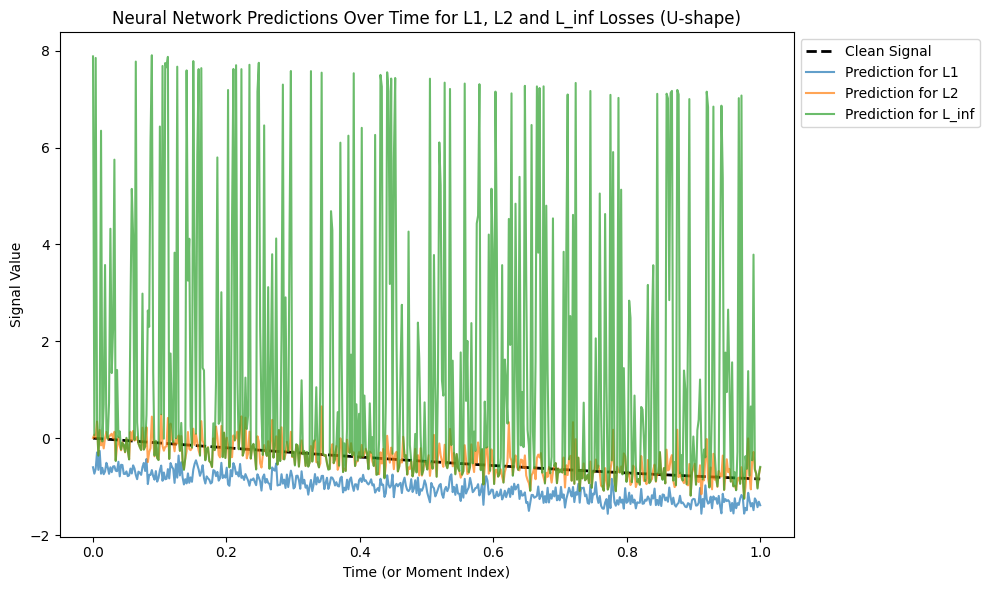

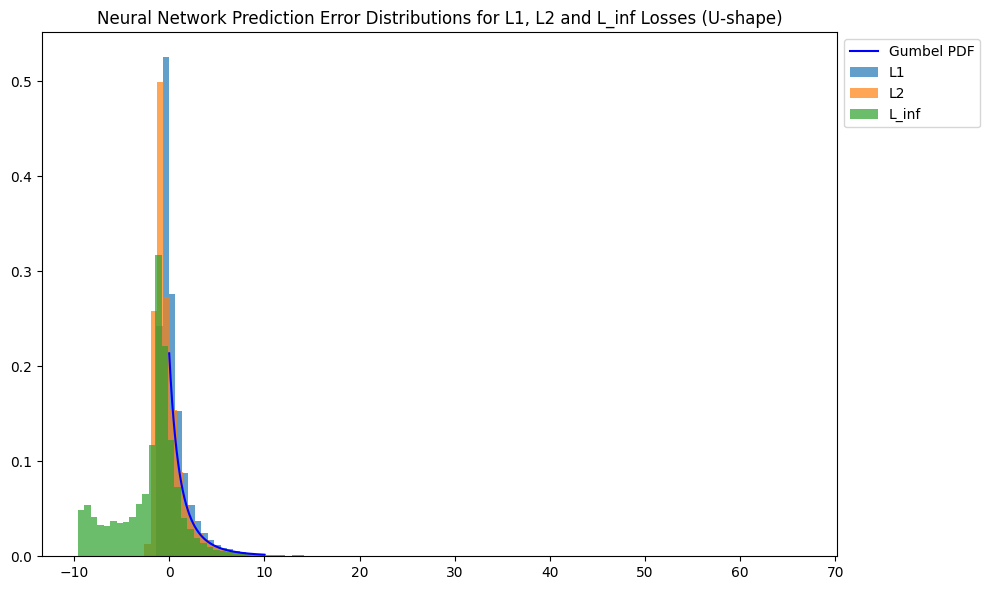

Observed Mean Difference:  0.5692
Theoretical Difference:  0.6487212707001282


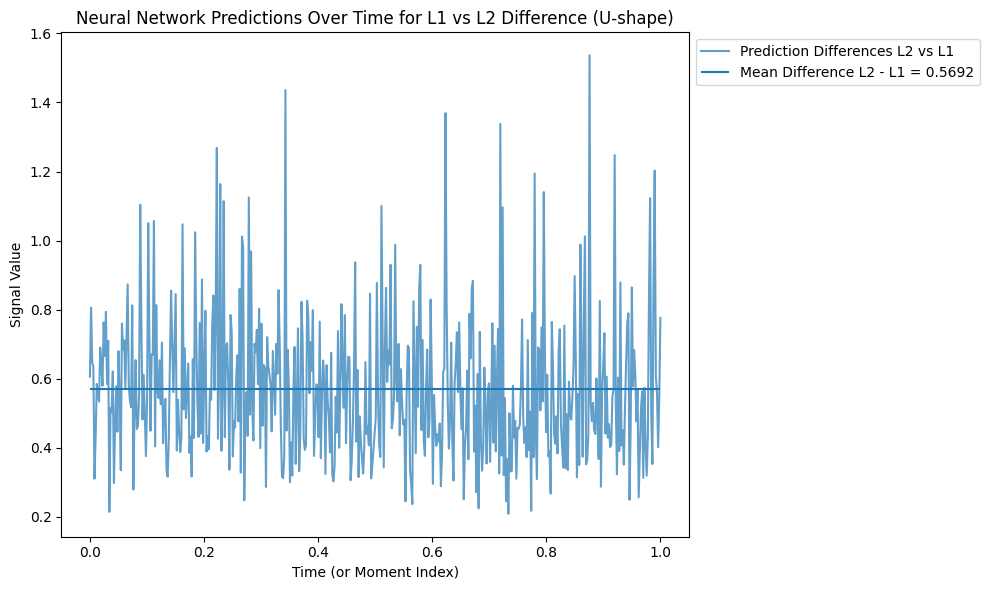

Training model for: Inverted U
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


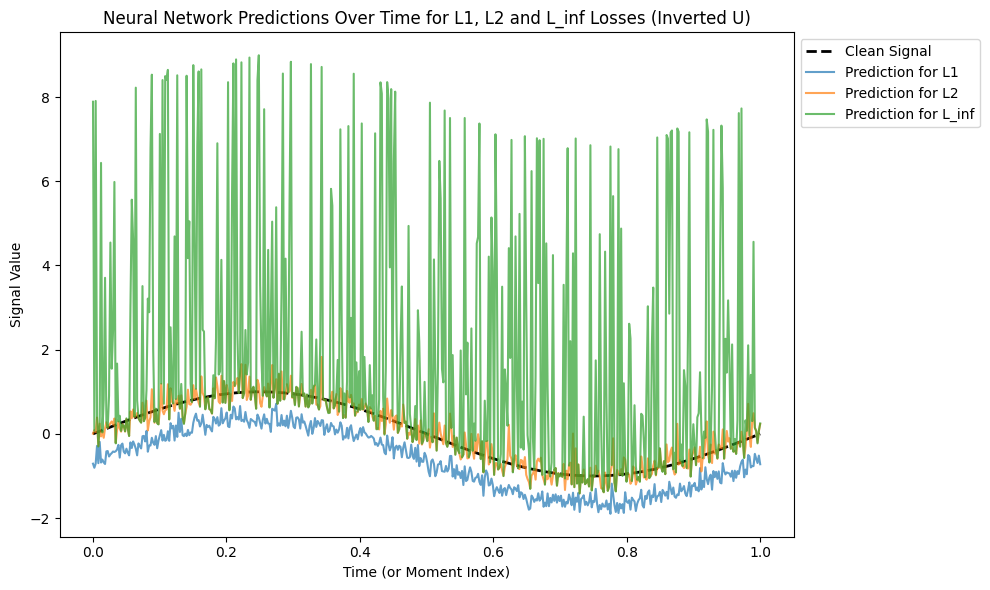

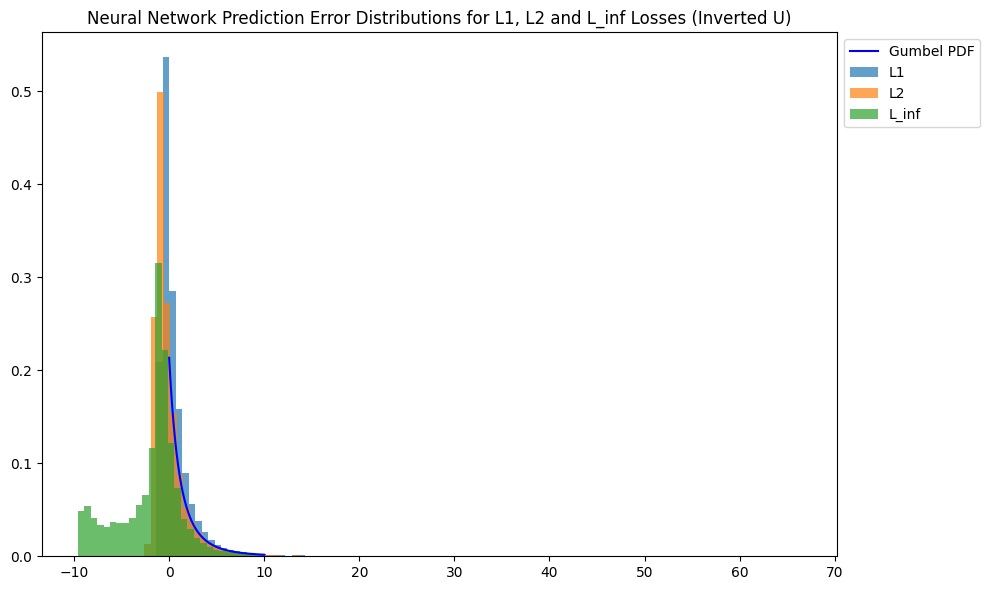

Observed Mean Difference:  0.6554
Theoretical Difference:  0.6487212707001282


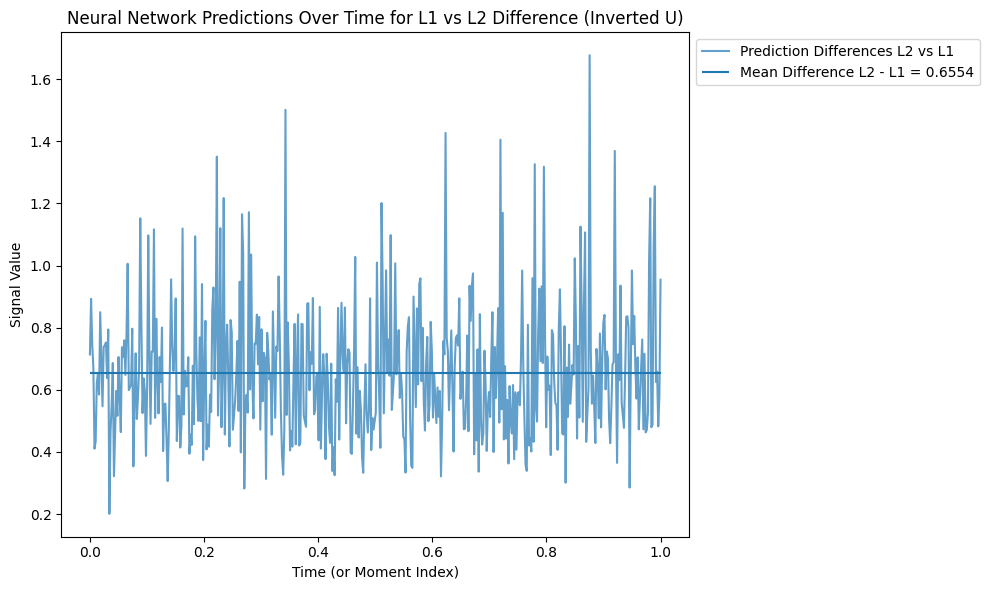

Training model for: Half U
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


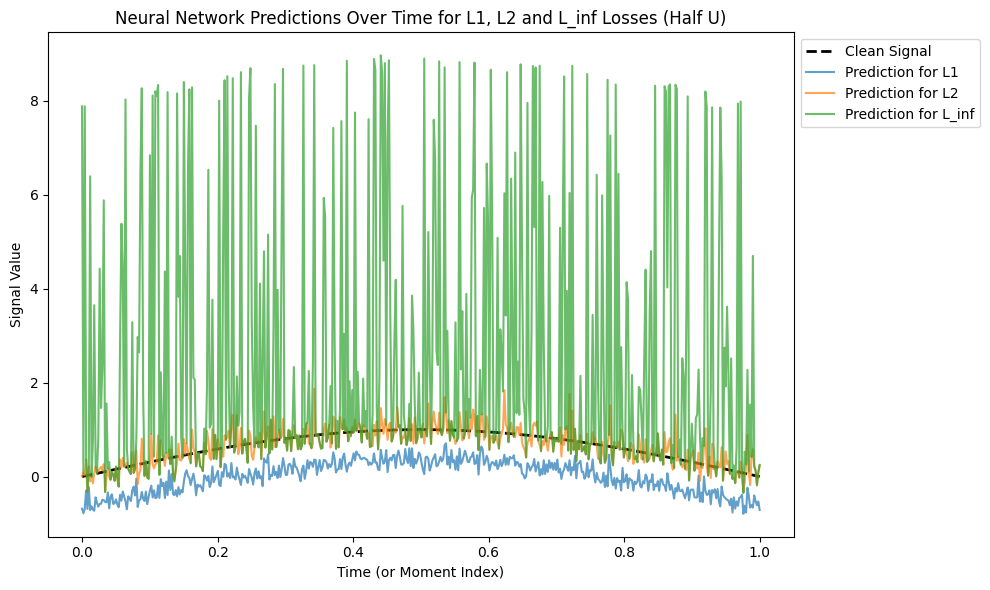

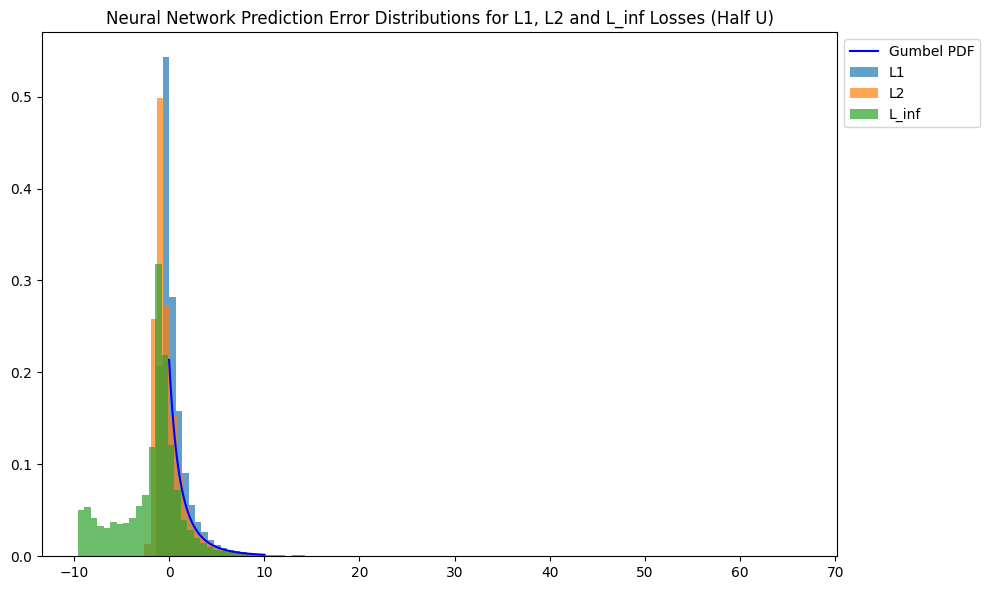

Observed Mean Difference:  0.6462
Theoretical Difference:  0.6487212707001282


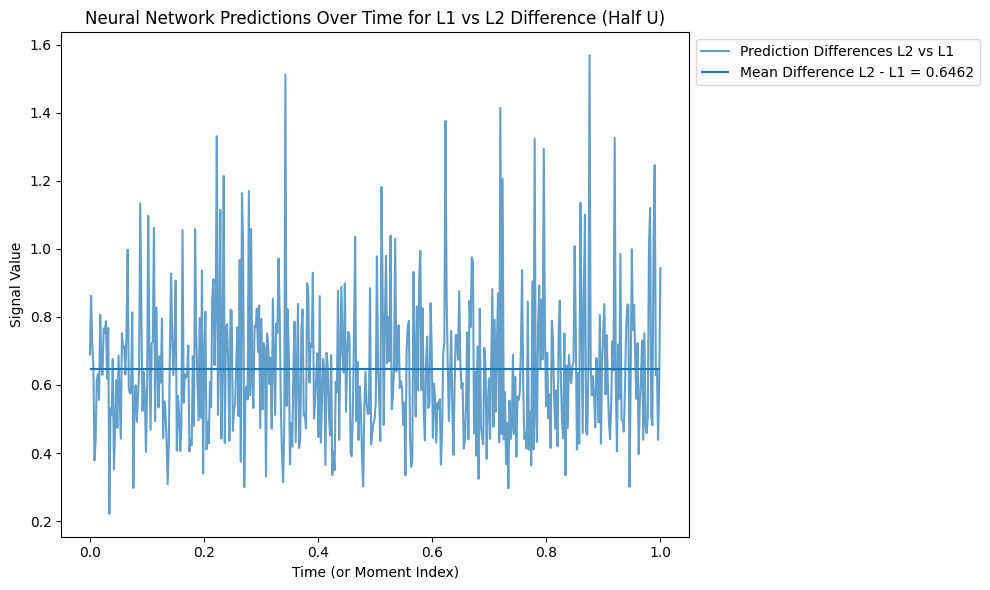

In [ ]:
# Seed
seed = 3254
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

# Loss functions dictionary
loss_functions = {
    "L1": "mae",
    "L2": "mse",
    "L_inf": l_infinity_loss,
}

# NN and series specifications
seq_length = 500   # number of time steps (moments)
num_examples = 100  # number of examples (noise realizations)
batch_size = 16
epochs = 250
learning_rate = 0.01
x = np.linspace(0, 1, seq_length)

# Different sine wave variations
y_clean_dict = {
    "U-shape": np.sin(x + 3*np.pi),  # Original
    "Inverted U": np.sin(2 * np.pi * x),  # One full oscillation
    "Half U": np.sin(np.pi * x)  # Half oscillation
}

# Noise parameters
mean=0
sigma=1  # for lower values, results vary more or less randomly, but with high values it seems to be near the expected
theory_mean = np.exp(mean+(sigma**2)/2)
theory_median = np.exp(mean)

mean_array = np.array([theory_mean] * (num_examples * seq_length)).reshape(num_examples, seq_length)
median_array = np.array([theory_median] * (num_examples * seq_length)).reshape(num_examples, seq_length)

# PDF

x_pdf = np.linspace(0, 10, 1000)
pdf = lognorm.pdf(x_pdf, s=sigma, scale=np.exp(mean), loc=-np.exp(mean+(sigma**2)/2))

for shape, y_clean in y_clean_dict.items():
    print(f"Training model for: {shape}")
    
    # Create arrays
    x_repeated = np.tile(x, (num_examples, 1))
    np.random.seed(32)
    noise = np.random.lognormal(mean=mean, sigma=sigma, size=num_examples * seq_length).reshape(num_examples, seq_length)
    data = np.tile(y_clean, (num_examples, 1)) + noise - mean_array
    target = np.tile(y_clean, (num_examples, 1))

    # Create and estimate models
    model = keras.models.Sequential([
        keras.layers.Input(shape=(seq_length,)),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(seq_length, activation='linear')
    ])

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    predict = {}
    errors = {}

    for title, selected_loss in loss_functions.items():
        model.compile(optimizer=optimizer, loss=selected_loss)
        model.fit(x=x_repeated, y=data, batch_size=batch_size, epochs=epochs, verbose=0)
        predictions = model.predict(x_repeated)
        predict[title] = predictions[0]
        errors[title] = data - np.array(predictions[0])

In [ ]:
# Plot results for L1, L2 and L_inf losses

plt.figure(figsize=(10, 6))
plt.plot(x, y_clean, 'k--', linewidth=2, label='Clean Signal')
plt.plot(x, predict["L1"], label=f'Prediction for L1', alpha=0.7)
plt.plot(x, predict["L2"], label=f'Prediction for L2', alpha=0.7)
plt.plot(x, predict["L_inf"], label=f'Prediction for L_inf', alpha=0.7)
plt.xlabel("Time (or Moment Index)")
plt.ylabel("Signal Value")
plt.title(f"Neural Network Predictions Over Time for L1, L2 and L_inf Losses ({shape})")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

# Plot results for L1, L2 and L_inf losses
plt.figure(figsize=(10, 6))
plt.plot(x_pdf, pdf, label='Gumbel PDF', color='blue')
plt.hist(errors["L1"].flatten(), bins=100, alpha=0.7, label='L1', density=True)
plt.hist(errors["L2"].flatten(), bins=100, alpha=0.7, label='L2', density=True)
plt.hist(errors["L_inf"].flatten(), bins=100, alpha=0.7, label='L_inf', density=True)
plt.title(f"Neural Network Prediction Error Distributions for L1, L2 and L_inf Losses ({shape})")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

# Compute and plot difference between L2 and L1 predictions
diff_series = np.array(predict["L2"]-predict["L1"])
diff_mean = np.mean(predict["L2"]-predict["L1"])
mean_rounded = str(round(diff_mean,4))
theoretical_diff = theory_mean-np.exp(mean)

print("Observed Mean Difference: ", mean_rounded)
print("Theoretical Difference: ", theoretical_diff)

plt.figure(figsize=(10, 6))
plt.plot(x, diff_series, label=f'Prediction Differences L2 vs L1', alpha=0.7)
plt.hlines(y=diff_mean, label=f'Mean Difference L2 - L1 = {mean_rounded}', xmin=0, xmax=1)
plt.xlabel("Time (or Moment Index)")
plt.ylabel("Signal Value")
plt.title(f"Neural Network Predictions Over Time for L1 vs L2 Difference ({shape})")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

### Cauchy

In [ ]:
# Seed
seed = 3254
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

# Loss functions dictionary
loss_functions = {
    "L1": "mae",
    "L2": "mse",
    "L_inf": l_infinity_loss,
}

# NN and series specifications
seq_length = 500   # number of time steps (moments)
num_examples = 100  # number of examples (noise realizations)
batch_size = 16
epochs = 250
learning_rate = 0.01
x = np.linspace(0, 1, seq_length)

# Different sine wave variations
y_clean_dict = {
    "U-shape": np.sin(x + 3*np.pi),  # Original
    "Inverted U": np.sin(2 * np.pi * x),  # One full oscillation
    "Half U": np.sin(np.pi * x)  # Half oscillation
}

# Noise parameters
mean=0
sigma=1  # for lower values, results vary more or less randomly, but with high values it seems to be near the expected
theory_median = mean

median_array = np.array([theory_median] * (num_examples * seq_length)).reshape(num_examples, seq_length)

# PDF

x_pdf = np.linspace(0, 10, 1000)
pdf = cauchy.pdf(x_pdf)

for shape, y_clean in y_clean_dict.items():
    print(f"Training model for: {shape}")
    
    # Create arrays
    x_repeated = np.tile(x, (num_examples, 1))
    np.random.seed(32)
    noise = np.random.standard_cauchy(size=num_examples * seq_length).reshape(num_examples, seq_length)
    data = np.tile(y_clean, (num_examples, 1)) + noise - median_array
    target = np.tile(y_clean, (num_examples, 1))

    # Create and estimate models
    model = keras.models.Sequential([
        keras.layers.Input(shape=(seq_length,)),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(seq_length, activation='linear')
    ])

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    predict = {}
    errors = {}

    for title, selected_loss in loss_functions.items():
        model.compile(optimizer=optimizer, loss=selected_loss)
        model.fit(x=x_repeated, y=data, batch_size=batch_size, epochs=epochs, verbose=0)
        predictions = model.predict(x_repeated)
        predict[title] = predictions[0]
        errors[title] = data - np.array(predictions[0])

Training model for: U-shape
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Training model for: Inverted U
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Training model for: Half U
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


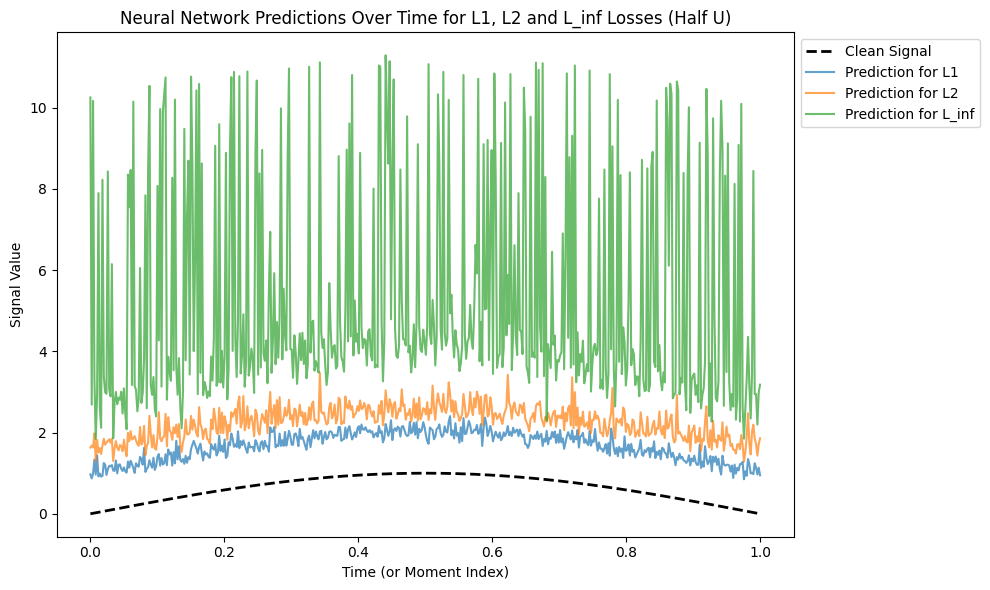

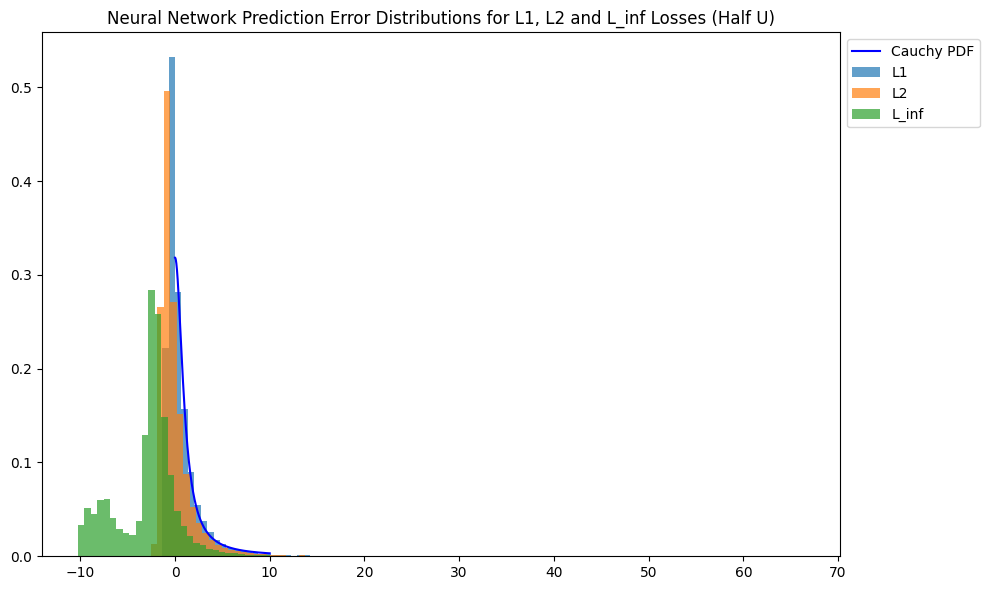

NameError: name 'theory_mean' is not defined

In [ ]:
# Plot results for L1, L2 and L_inf losses
plt.figure(figsize=(10, 6))
plt.plot(x, y_clean, 'k--', linewidth=2, label='Clean Signal')
plt.plot(x, predict["L1"], label=f'Prediction for L1', alpha=0.7)
plt.plot(x, predict["L2"], label=f'Prediction for L2', alpha=0.7)
plt.plot(x, predict["L_inf"], label=f'Prediction for L_inf', alpha=0.7)
plt.xlabel("Time (or Moment Index)")
plt.ylabel("Signal Value")
plt.title(f"Neural Network Predictions Over Time for L1, L2 and L_inf Losses ({shape})")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

# Plot results for L1, L2 and L_inf losses
plt.figure(figsize=(10, 6))
plt.plot(x_pdf, pdf, label='Cauchy PDF', color='blue')
plt.hist(errors["L1"].flatten(), bins=100, alpha=0.7, label='L1', density=True)
plt.hist(errors["L2"].flatten(), bins=100, alpha=0.7, label='L2', density=True)
plt.hist(errors["L_inf"].flatten(), bins=100, alpha=0.7, label='L_inf', density=True)
plt.title(f"Neural Network Prediction Error Distributions for L1, L2 and L_inf Losses ({shape})")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

# Compute and plot difference between L2 and L1 predictions
diff_series = np.array(predict["L2"]-predict["L1"])
diff_mean = np.mean(predict["L2"]-predict["L1"])
mean_rounded = str(round(diff_mean,4))

print("Observed Mean Difference: ", mean_rounded)

plt.figure(figsize=(10, 6))
plt.plot(x, diff_series, label=f'Prediction Differences L2 vs L1', alpha=0.7)
plt.hlines(y=diff_mean, label=f'Mean Difference L2 - L1 = {mean_rounded}', xmin=0, xmax=1)
plt.xlabel("Time (or Moment Index)")
plt.ylabel("Signal Value")
plt.title(f"Neural Network Predictions Over Time for L1 vs L2 Difference ({shape})")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

### Financial Time Series

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


[[ 72.71605682]
 [ 72.0091095 ]
 [ 72.58291626]
 ...
 [255.30929565]
 [251.92301941]
 [250.14497375]]
Training model with L1 loss function.
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Training model with L2 loss function.
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Training model with Huber loss function.
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


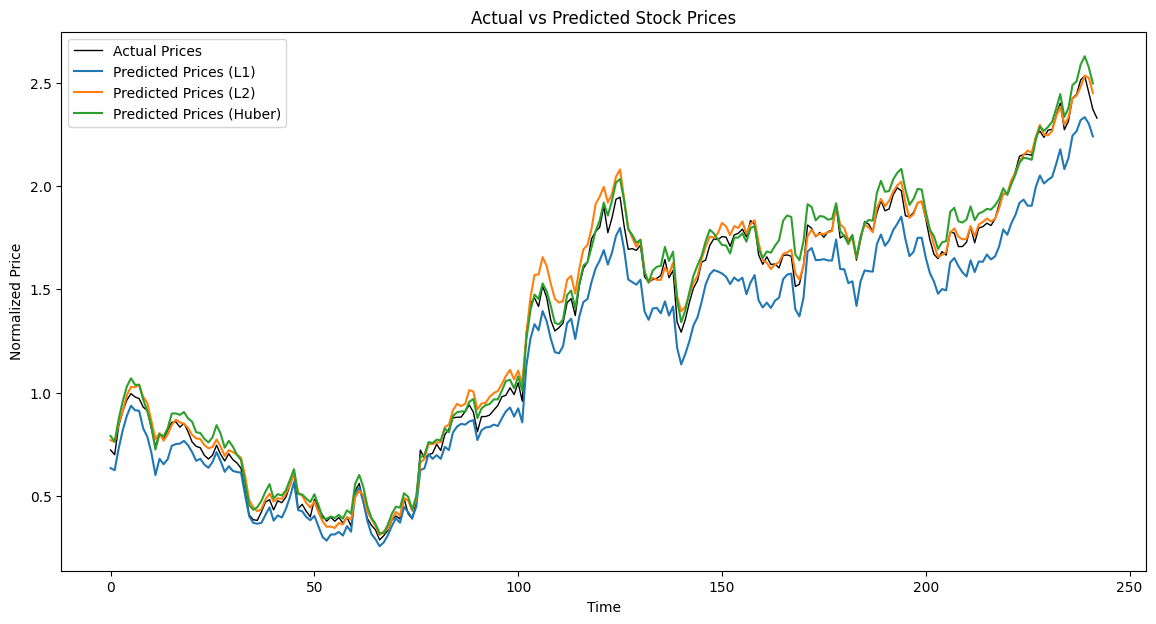

Observed Mean Difference between L2 and L1 predictions:  0.1555


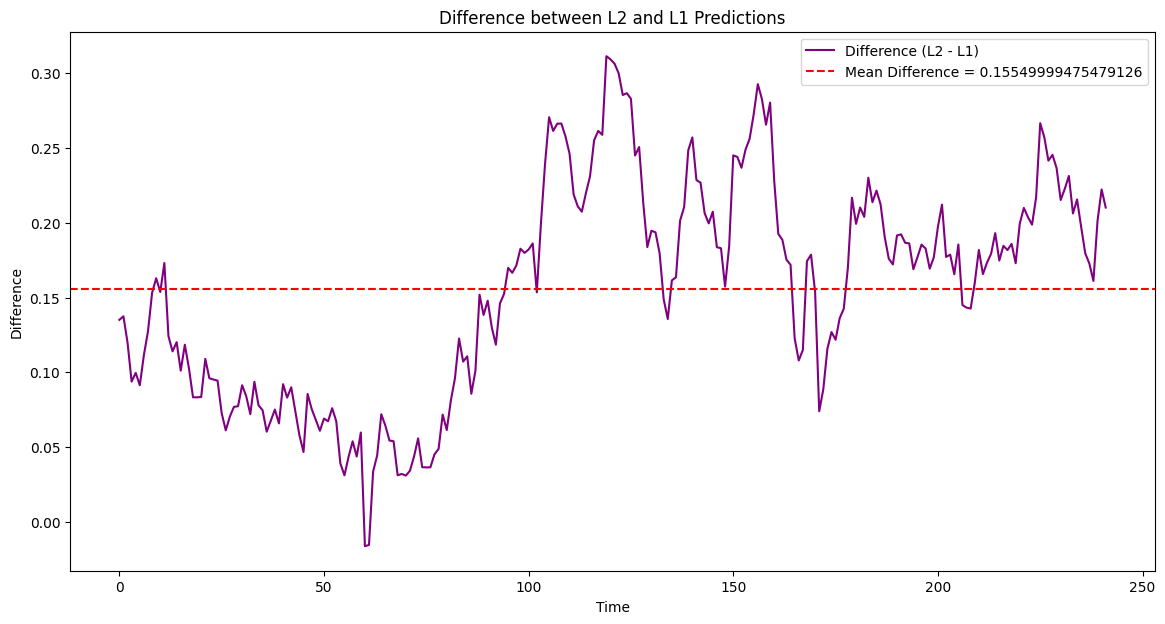

In [ ]:
# Plot actual vs predicted prices
plt.figure(figsize=(14, 7))
plt.plot(range(len(stock_prices[1015:])), stock_prices[1015:], label='Actual Prices', color='black', linewidth=1)
for title, predictions in predict.items():
    plt.plot(range( len(predictions)), predictions, label=f'Predicted Prices ({title})')
plt.xlabel('Time')
plt.ylabel('Normalized Price')
plt.title('Actual vs Predicted Stock Prices')
plt.legend()
plt.show()

# Compute and plot difference between L2 and L1 predictions
diff_series = predict["L2"] - predict["L1"]
diff_mean = np.mean(diff_series)
mean_rounded = round(diff_mean, 4)

print("Observed Mean Difference between L2 and L1 predictions: ", mean_rounded)

plt.figure(figsize=(14, 7))
plt.plot(range(len(diff_series)), diff_series, label='Difference (L2 - L1)', color='purple')
plt.axhline(y=diff_mean, color='red', linestyle='--', label=f'Mean Difference = {mean_rounded}')
plt.xlabel('Time')
plt.ylabel('Difference')
plt.title('Difference between L2 and L1 Predictions')
plt.legend()
plt.show()

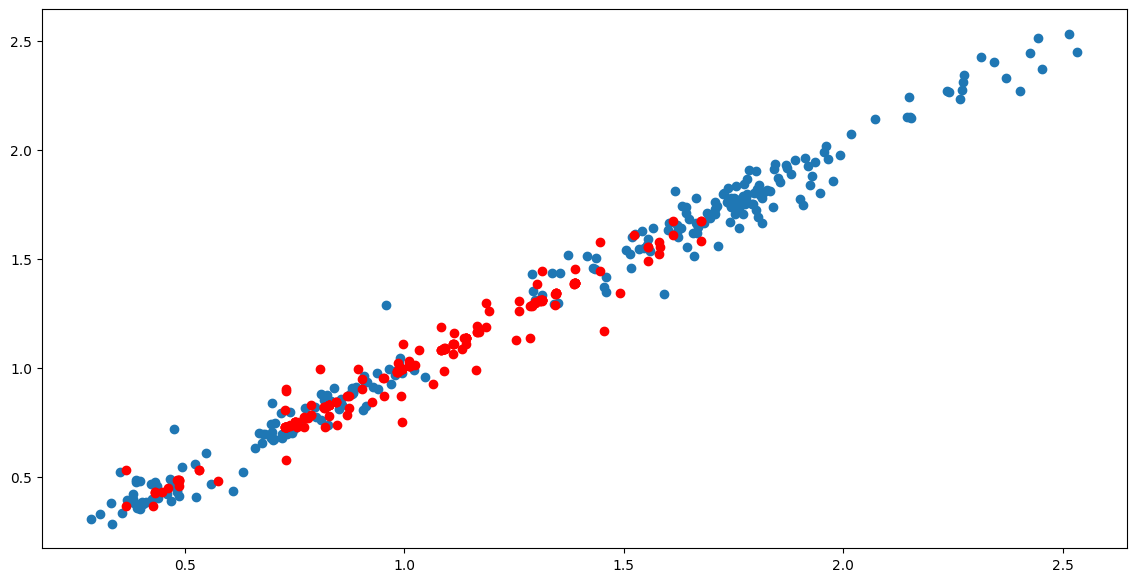

In [ ]:
plt.figure(figsize=(14, 7))
plt.scatter(stock_prices[1015:-1],stock_prices[1016:])
plt.scatter(predictions[:-1],predictions[1:],color='red')
plt.show()

In [ ]:
# Load environment variables
load_dotenv(".env")
api_key = os.getenv("BINANCE_API_KEY")
secret_key = os.getenv("BINANCE_SECRET_KEY")
exchange_name = "binance"  # or use ExchangeNames.binance if it's an enum

# Initialize the Binance API
binance_api = BinanceProvider(api_key=api_key, api_secret=secret_key)
binance_api.connect()

# Loss functions dictionary
loss_functions = {
    "L1": "mae",
    "L2": "mse",
    "L_inf": l_infinity_loss,
}

# Define sequence length
seq_length = 1

# Prepare model building function
def build_model():
    model = keras.models.Sequential([
        keras.layers.Input(shape=(seq_length,)),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(1, activation='linear')
    ])
    return model

# Loop over the token pairs you want to use
token_pairs = [TokenPairs.btc_usdt, TokenPairs.eth_usdt]
predict_results = {}

# Loop over the token pairs and train a model for each one
for token_pair in token_pairs:
    print(f"Training model for: {token_pair}")

    # Fetch historical data from Binance for the given token pair
    start = datetime(2020, 1, 1)
    end = datetime(2025, 1, 1)
    
    # Fetch market data (klines) for the token pair from Binance
    btc_klines = binance_api.get_market_data(symbol=token_pair, freq="1d", start=start, end=end)
    token_prices = np.array(btc_klines['close'])

    # Normalize token prices
    token_prices = (token_prices - np.mean(token_prices)) / np.std(token_prices)

    # Prepare input sequences and corresponding targets
    X = []
    y = []
    for i in range(len(token_prices) - seq_length):
        X.append(token_prices[i:i + seq_length])  # temporal sequence
        y.append(token_prices[i + seq_length])    # next price value

    X = np.array(X)
    y = np.array(y)

    # Split into training and testing sets
    split = int(0.7 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split].reshape(-1, 1), y[split:].reshape(-1, 1)

    # Training models for each loss function
    for title, selected_loss in loss_functions.items():
        print(f"Training model with {title} loss function.")
        model = build_model()
        optimizer = keras.optimizers.Adam(learning_rate=0.01)
        model.compile(optimizer=optimizer, loss=selected_loss)
        model.fit(X_train, y_train, batch_size=16, epochs=100, verbose=0)
        
        # Predict on the test set
        predictions = model.predict(X_test).flatten()
        
        # Store predictions for later use or plotting
        if token_pair not in predict_results:
            predict_results[token_pair] = {}
        predict_results[token_pair][title] = predictions



Succesfully connected to the Binance Spot API at 2025-03-21 09:21:29.240333 

Succesfully connected to the Binance Futures API at 2025-03-21 09:21:29.592491 

Training model for: TokenPairs.btc_usdt
Training model with L1 loss function.
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Training model with L2 loss function.
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Training model with L_inf loss function.
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Training model for: TokenPairs.eth_usdt
Training model with L1 loss function.
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Training model with L2 loss function.
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Training model with L_inf loss function.
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


Plotting for TokenPairs.btc_usdt


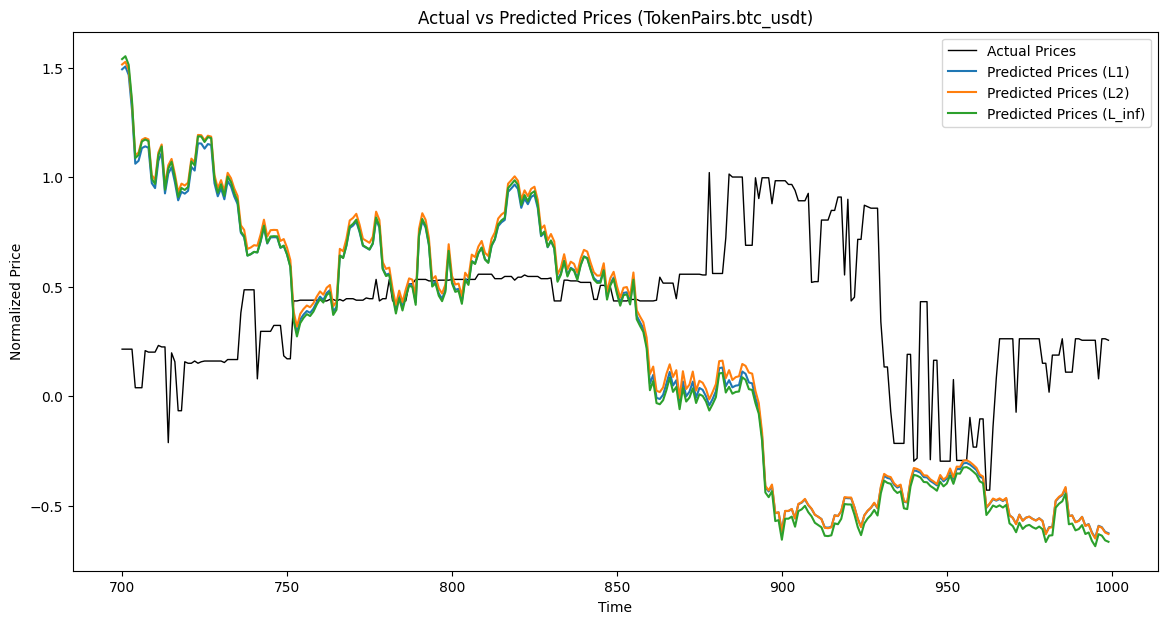

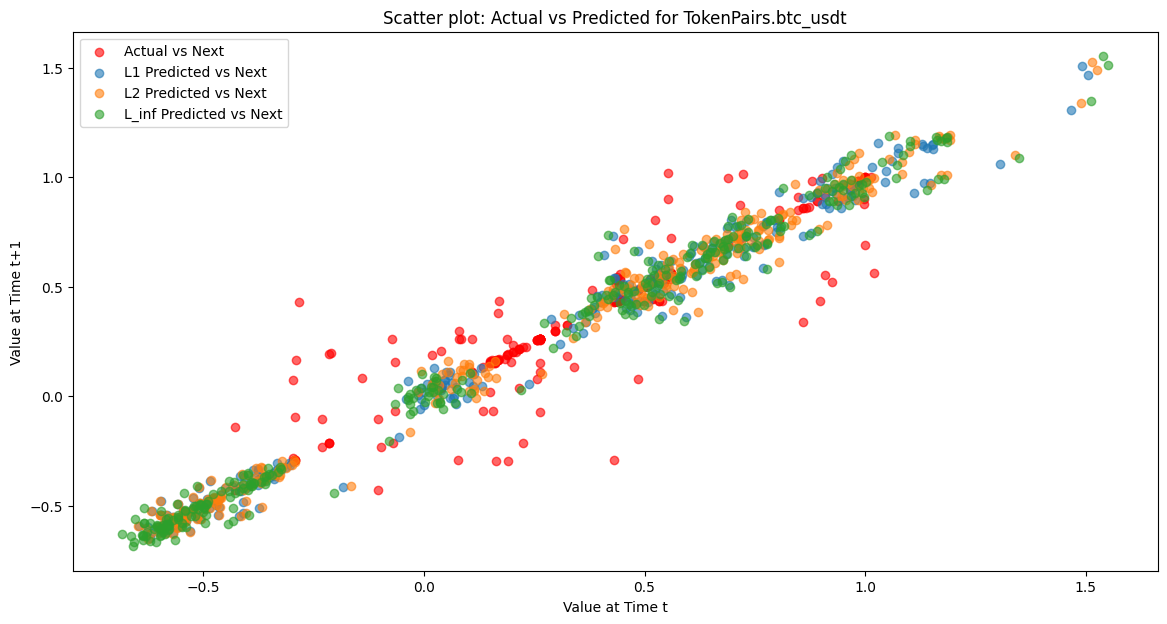

Observed Mean Difference between L2 and L1 predictions for TokenPairs.btc_usdt:  0.0216


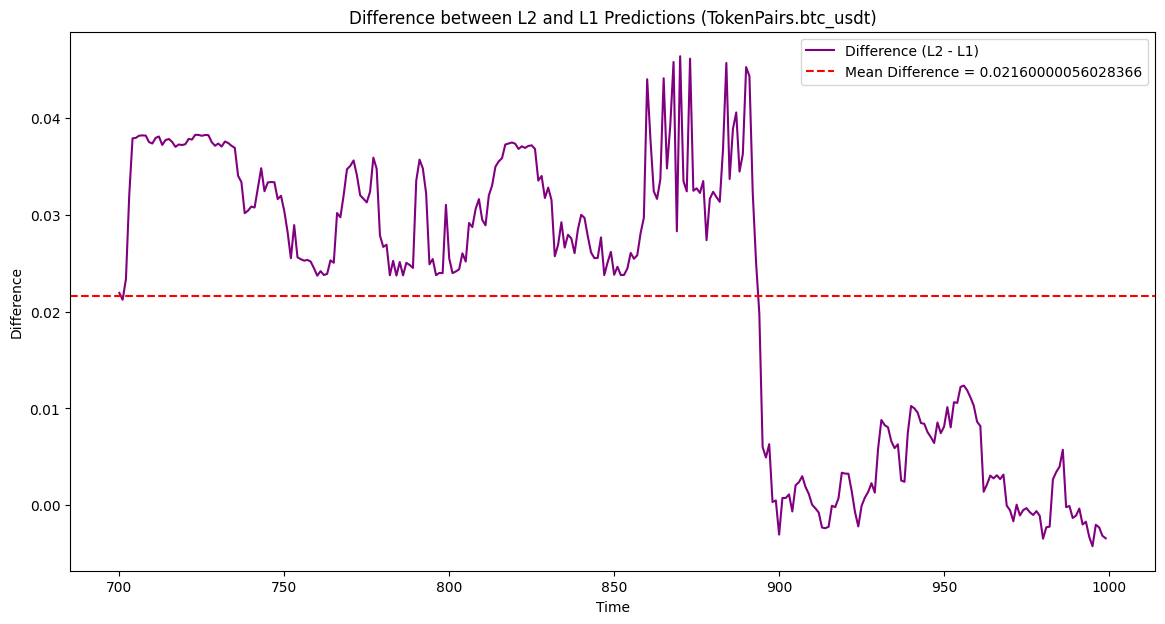

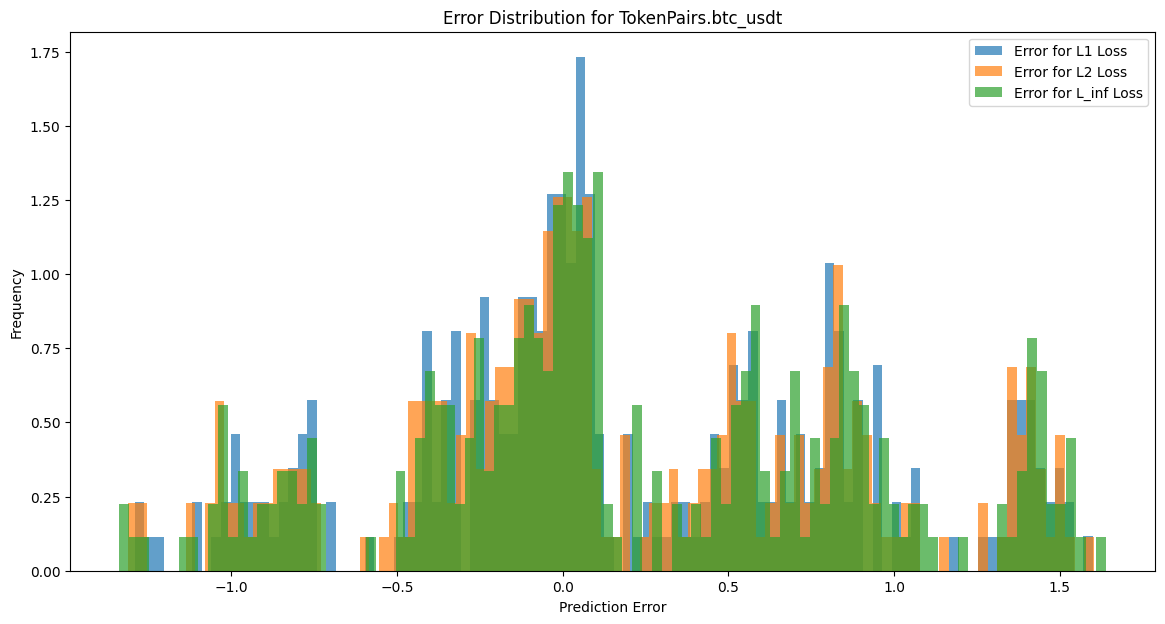

Plotting for TokenPairs.eth_usdt


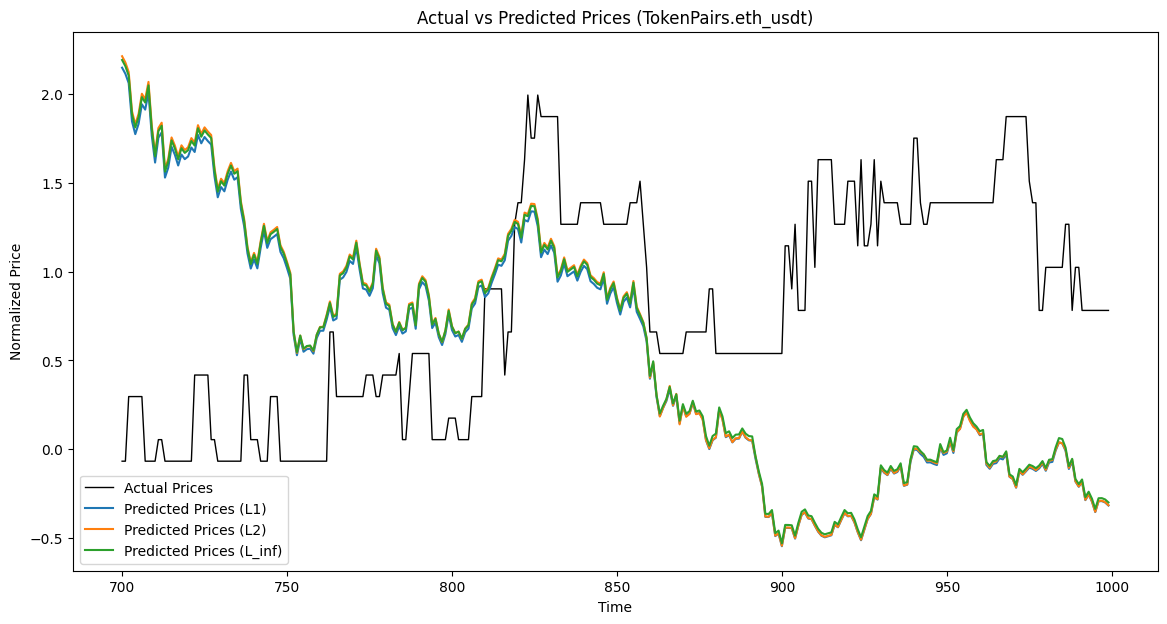

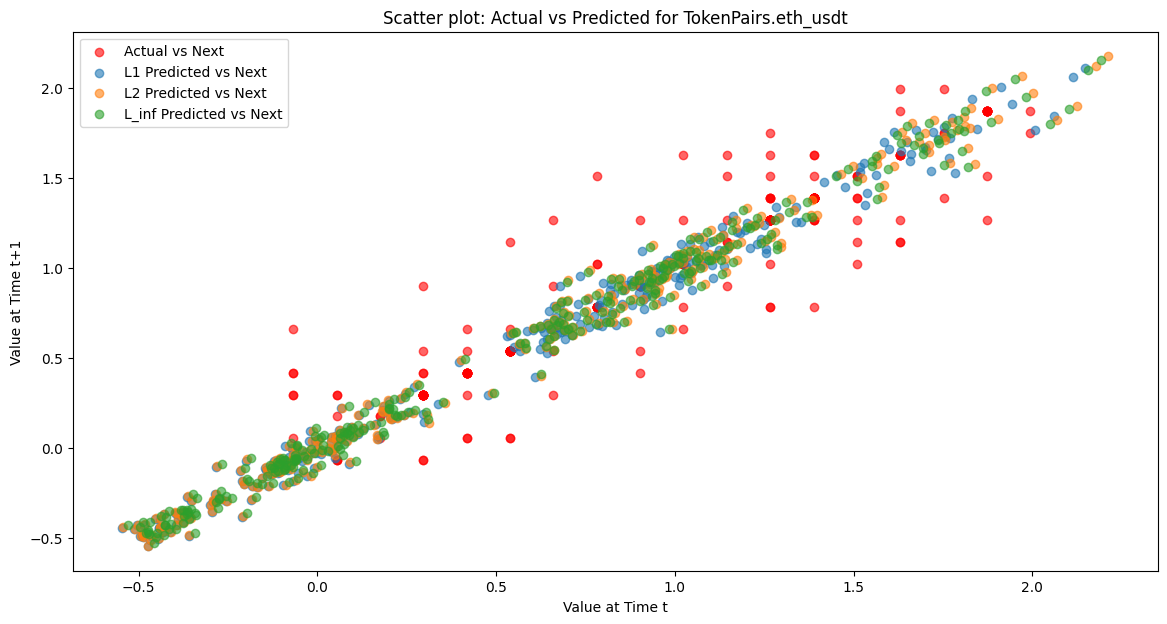

Observed Mean Difference between L2 and L1 predictions for TokenPairs.eth_usdt:  0.0209


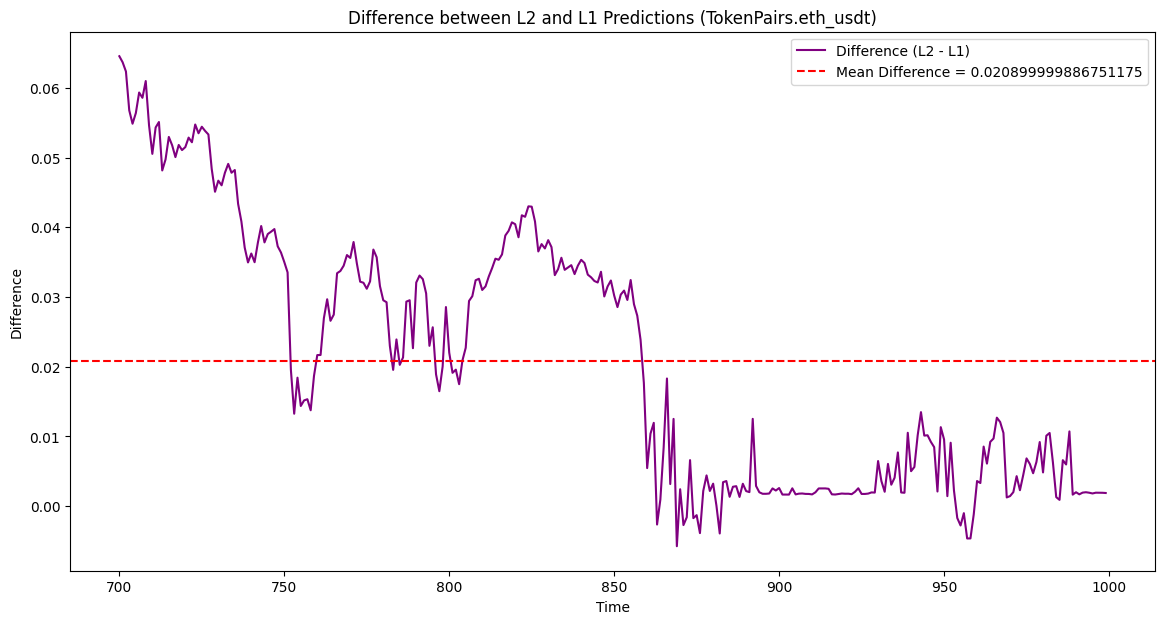

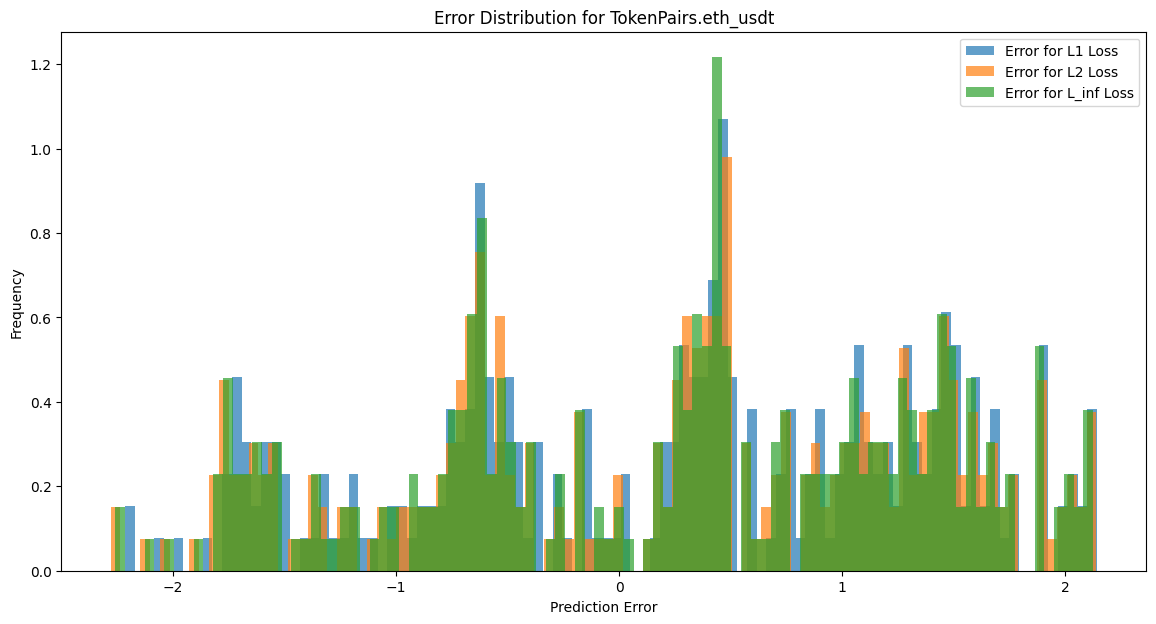

In [ ]:
# Assuming predict_results stores predictions for both BTC and ETH pairs
for token_pair, predictions_dict in predict_results.items():
    print(f"Plotting for {token_pair}")

    # Extract the actual data (the normalized token prices for this token pair)
    token_prices = np.array(binance_api.get_market_data(symbol=token_pair, freq="1s", start=start, end=end)['close'])
    normalized_prices = (token_prices - np.mean(token_prices)) / np.std(token_prices)

    # Calculate the starting index dynamically (using the sequence length)
    start_index = len(normalized_prices) - len(predictions_dict["L1"])  # or any other loss function predictions
    
    # Plot Actual vs Predicted Prices
    plt.figure(figsize=(14, 7))
    plt.plot(range(start_index, len(normalized_prices)), normalized_prices[start_index:], label='Actual Prices', color='black', linewidth=1)
    for title, predictions in predictions_dict.items():
        plt.plot(range(start_index, len(predictions) + start_index), predictions, label=f'Predicted Prices ({title})')
    plt.xlabel('Time')
    plt.ylabel('Normalized Price')
    plt.title(f'Actual vs Predicted Prices ({token_pair})')
    plt.legend()
    plt.show()

    # Scatter plot: Actual values vs next values (Actual prices vs predictions)
    plt.figure(figsize=(14, 7))
    plt.scatter(normalized_prices[start_index:-1], normalized_prices[start_index+1:], label='Actual vs Next', color='red', alpha=0.6)
    
    for title, predictions in predictions_dict.items():
        plt.scatter(predictions[:-1], predictions[1:], alpha=0.6, label=f'{title} Predicted vs Next')
    
    plt.xlabel('Value at Time t')
    plt.ylabel('Value at Time t+1')
    plt.title(f'Scatter plot: Actual vs Predicted for {token_pair}')
    plt.legend()
    plt.show()

    # Compute and plot difference between L2 and L1 predictions
    if "L2" in predictions_dict and "L1" in predictions_dict:
        diff_series = predictions_dict["L2"] - predictions_dict["L1"]
        diff_mean = np.mean(diff_series)
        mean_rounded = round(diff_mean, 4)

        print(f"Observed Mean Difference between L2 and L1 predictions for {token_pair}: ", mean_rounded)

        plt.figure(figsize=(14, 7))
        plt.plot(range(start_index, start_index + len(diff_series)), diff_series, label='Difference (L2 - L1)', color='purple')
        plt.axhline(y=diff_mean, color='red', linestyle='--', label=f'Mean Difference = {mean_rounded}')
        plt.xlabel('Time')
        plt.ylabel('Difference')
        plt.title(f'Difference between L2 and L1 Predictions ({token_pair})')
        plt.legend()
        plt.show()

    # Calculate errors for each loss function (L1, L2, L_inf)
    errors = {}
    for loss_function, predictions in predictions_dict.items():
        errors[loss_function] = normalized_prices[start_index:start_index + len(predictions)] - predictions

    # Plot histograms of the errors for L1, L2, L_inf losses
    plt.figure(figsize=(14, 7))
    for loss_function, error in errors.items():
        plt.hist(error.flatten(), bins=100, alpha=0.7, label=f'Error for {loss_function} Loss', density=True)
    
    plt.xlabel('Prediction Error')
    plt.ylabel('Frequency')
    plt.title(f'Error Distribution for {token_pair}')
    plt.legend()
    plt.show()



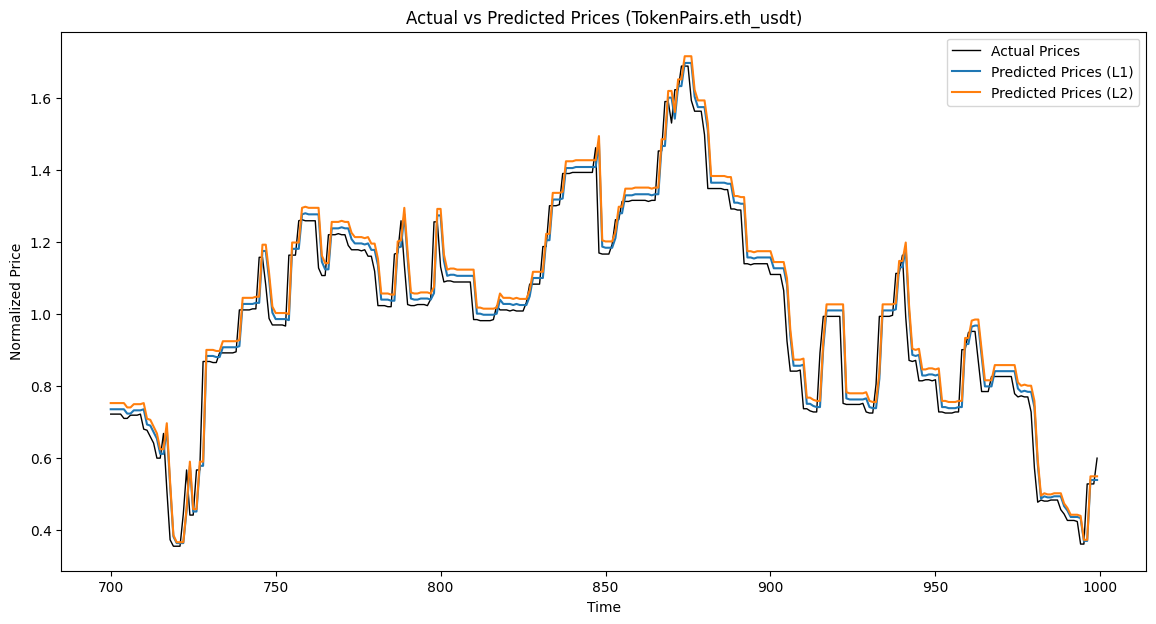

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(range(start_index, len(normalized_prices)), normalized_prices[start_index:], label='Actual Prices', color='black', linewidth=1)
plt.plot(range(start_index, len(predictions_dict["L1"]) + start_index), predictions_dict["L1"], label=f'Predicted Prices (L1)')
plt.plot(range(start_index, len(predictions_dict["L2"]) + start_index), predictions_dict["L2"], label=f'Predicted Prices (L2)')
plt.xlabel('Time')
plt.ylabel('Normalized Price')
plt.title(f'Actual vs Predicted Prices ({token_pair})')
plt.legend()
plt.show()

TO DO:

- Organizar
- Series Temporales (rendimientos: probar rendimientos)

1) Serie de precios
2) Serie de rendimientos
3) Entrenas con rendimientos
4) Predicciones con rendimientos
5) Reconstruir serie de precios a partir de predicciones con rendimientos

Estructura:

- Loss Functions
- L1, L2, L_inf
- Teoría Práctica: Gumbel, Log-normal, Cauchy
- Series Reales: intradía, diarias, etc. (para la observación de fenómenos); alguna serie con estacionariedad (no criptomonedas, algún commodity igual); periodos de estrés (ver parecidos con errores vistos)